In [1]:
#importing the required packages
import os
import matplotlib.pyplot as plt
import numpy as np
from keras import backend
import argparse
import random
import cv2
import glob

C:\Users\NiranjanKumar\Anaconda3\envs\deep\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [3]:
dataset_path = "Data\\gender_dataset_face-backup"

In [8]:
# initial parameters
epochs = 100
lr_rate = 1e-3
batch_size = 64
img_dims = (96,96,3)
drop_out = 0.15

data = []
labels = []

In [9]:
# load image files from the dataset
random.seed(42)
image_files = [f for f in glob.glob(dataset_path + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [10]:
# create groud-truth label from the image path
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label])

In [13]:
len(data)

6761

In [14]:
len(labels)

6761

In [16]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [17]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, 
                         width_shift_range=0.1,
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2,
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [18]:
print("training x length: ", len(trainX))
print("testing x length: ", len(testY))

training x length:  5408
testing x length:  1353


### CNN

In [19]:
#Creating a function for saving the model at each epoch end
class LossHistory(Callback):
    def __init__(self):
        super().__init__()
        self.epoch_id = 0
        self.losses = ''
 
    def on_epoch_end(self, epoch, logs={}):
        self.losses += "Epoch {}: accuracy -> {:.3f}, val_accuracy -> {:.3f}\n"\
            .format(str(self.epoch_id), logs.get('acc'), logs.get('val_acc'))
        self.epoch_id += 1
 
    def on_train_begin(self, logs={}):
        self.losses += 'Training begins...\n'

In [20]:
#Creating a checkpointer 
checkpointer = ModelCheckpoint(filepath= os.path.join('Detection\\Models', 'scratchmodel_gender1.hdf5'), 
                               verbose=1,save_best_only=True)

In [21]:
# Initialising the CNN
model = Sequential()

In [22]:
model.add(Conv2D(32, (3,3), padding="same", input_shape=(img_dims)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(drop_out))

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(drop_out))

model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(drop_out))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation("sigmoid"))

In [23]:
#compiling
optimizer = Adam(lr=lr_rate, decay= lr_rate/epochs)
metrics=['accuracy']
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

In [24]:
# Create a loss history
history = LossHistory()

In [25]:
# train the model
x = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, 
                        verbose=1, 
                        workers = 6, 
                        callbacks = [history, checkpointer], 
                        max_q_size = 100)

C:\Users\NiranjanKumar\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<__main__..., steps_per_epoch=84, max_queue_size=100, workers=6, epochs=100, validation_data=(array([[[..., verbose=1)`
  if __name__ == '__main__':


Epoch 1/100
 3/84 [>.............................] - ETA: 16:59 - loss: 1.0502 - acc: 0.6172

C:\Users\NiranjanKumar\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227398). Check your callbacks.
  % delta_t_median)


84/84 [==============================] - 57s 677ms/step - loss: 0.4717 - acc: 0.8210 - val_loss: 0.3603 - val_acc: 0.8596

Epoch 00001: val_loss improved from inf to 0.36033, saving model to Detection\Models\scratchmodel_gender1.hdf5
Epoch 2/100
84/84 [==============================] - 20s 236ms/step - loss: 0.3275 - acc: 0.8651 - val_loss: 0.2517 - val_acc: 0.9024

Epoch 00002: val_loss improved from 0.36033 to 0.25170, saving model to Detection\Models\scratchmodel_gender1.hdf5
Epoch 3/100
84/84 [==============================] - 20s 242ms/step - loss: 0.2622 - acc: 0.8930 - val_loss: 0.2460 - val_acc: 0.9109

Epoch 00003: val_loss improved from 0.25170 to 0.24603, saving model to Detection\Models\scratchmodel_gender1.hdf5
Epoch 4/100
84/84 [==============================] - 20s 238ms/step - loss: 0.2260 - acc: 0.9076 - val_loss: 0.3956 - val_acc: 0.8459

Epoch 00004: val_loss did not improve from 0.24603
Epoch 5/100
84/84 [==============================] - 19s 226ms/step - loss: 0.19

84/84 [==============================] - 19s 226ms/step - loss: 0.0379 - acc: 0.9863 - val_loss: 0.0458 - val_acc: 0.9819

Epoch 00041: val_loss did not improve from 0.03227
Epoch 42/100
84/84 [==============================] - 19s 227ms/step - loss: 0.0426 - acc: 0.9839 - val_loss: 0.0330 - val_acc: 0.9885

Epoch 00042: val_loss did not improve from 0.03227
Epoch 43/100
84/84 [==============================] - 19s 226ms/step - loss: 0.0470 - acc: 0.9824 - val_loss: 0.1531 - val_acc: 0.9616

Epoch 00043: val_loss did not improve from 0.03227
Epoch 44/100
84/84 [==============================] - 19s 228ms/step - loss: 0.0428 - acc: 0.9832 - val_loss: 0.0557 - val_acc: 0.9815

Epoch 00044: val_loss did not improve from 0.03227
Epoch 45/100
84/84 [==============================] - 19s 223ms/step - loss: 0.0362 - acc: 0.9888 - val_loss: 0.0567 - val_acc: 0.9819

Epoch 00045: val_loss did not improve from 0.03227
Epoch 46/100
84/84 [==============================] - 19s 227ms/step - loss: 0


Epoch 00084: val_loss did not improve from 0.02820
Epoch 85/100
84/84 [==============================] - 9s 108ms/step - loss: 0.0252 - acc: 0.9907 - val_loss: 0.0320 - val_acc: 0.9885

Epoch 00085: val_loss did not improve from 0.02820
Epoch 86/100
84/84 [==============================] - 9s 106ms/step - loss: 0.0268 - acc: 0.9887 - val_loss: 0.0242 - val_acc: 0.9911

Epoch 00086: val_loss improved from 0.02820 to 0.02416, saving model to Detection\Models\scratchmodel_gender1.hdf5
Epoch 87/100
84/84 [==============================] - 9s 110ms/step - loss: 0.0233 - acc: 0.9919 - val_loss: 0.0286 - val_acc: 0.9922

Epoch 00087: val_loss did not improve from 0.02416
Epoch 88/100
84/84 [==============================] - 9s 110ms/step - loss: 0.0226 - acc: 0.9919 - val_loss: 1.1881 - val_acc: 0.8477oss: 0.0224 - acc:

Epoch 00088: val_loss did not improve from 0.02416
Epoch 89/100
84/84 [==============================] - 9s 111ms/step - loss: 0.0328 - acc: 0.9877 - val_loss: 0.0509 - val_

In [26]:
x.history.keys()

dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])

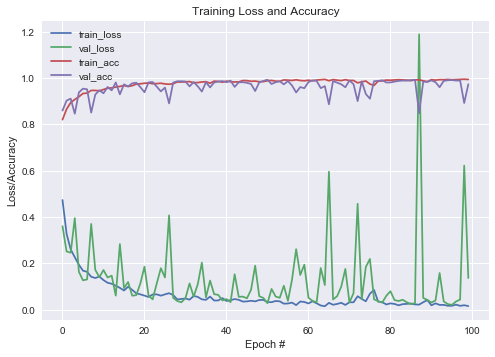

In [29]:
# plot training/validation loss/accuracy
plt.style.use("seaborn")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), x.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), x.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), x.history["acc"], label="train_acc")
plt.plot(np.arange(0,N), x.history["val_acc"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

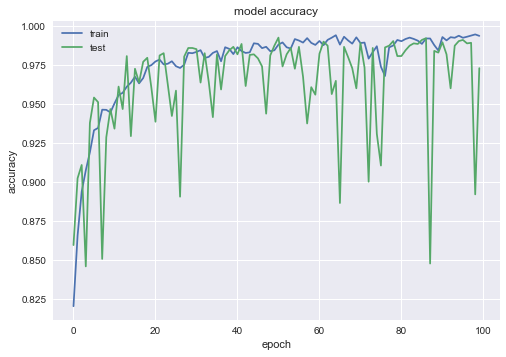

In [30]:
# summarize history for accuracy
plt.plot(x.history['acc'])
plt.plot(x.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

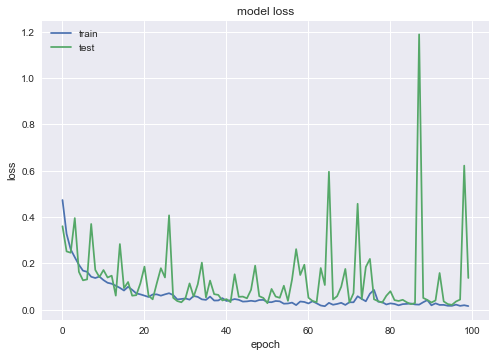

In [31]:
# summarize history for loss
plt.plot(x.history['loss'])
plt.plot(x.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
score = model.evaluate(testX, testY)
print("Accuracy on test data:", score[1])

1353/1353 [==============================] - 1s 684us/step
Accuracy on test data: 0.9730229120473023


In [33]:
# Save loss history to file
loss_history_path = os.path.join('Detection\\Models', 'scratchmodel_gender1.log')
myFile = open(loss_history_path, 'w+')
myFile.write(history.losses)
myFile.close()

In [34]:
backend.clear_session()